# Atividade Edenred

## <font color='Red'>Ambiente de Execução</font>

In [4]:

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import folium
from geopy.geocoders import Nominatim
import squarify
import osmnx as ox
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose



## <font color='Red'>Balança Comercial</font>

### <font color='Grey'>Formatação e Pré-processamento</font>


Baixando o banco de dados.

In [5]:
balanca = pd.read_csv('balanca_comercial.csv', skiprows = 1, encoding = 'latin1')

Removendo os NaN do banco para deixá-lo mais legível. Removendo a coluna 'System of trade footnote', que possui apenas dados de NaN.

In [6]:
balanca['Footnotes'] = balanca['Footnotes'].fillna('-')

balanca['System of trade'] = balanca['System of trade'].fillna('-')

balanca = balanca.drop('System of trade footnote', axis=1)

balanca.columns.values[1] = 'Country'

In [7]:
balanca['Value'] = balanca['Value'].str.replace(',', '').astype(float)

In [8]:
balanca

,Region/Country/Area,Country,Year,Series,System of trade,Value,Footnotes,Source
0,1,"Total, all countries or areas",1995,Imports CIF (millions of US dollars),-,5099057.0,-,"United Nations Statistics Division, New York, ..."
1,1,"Total, all countries or areas",2005,Imports CIF (millions of US dollars),-,10577013.0,-,"United Nations Statistics Division, New York, ..."
2,1,"Total, all countries or areas",2010,Imports CIF (millions of US dollars),-,15275115.0,-,"United Nations Statistics Division, New York, ..."
3,1,"Total, all countries or areas",2015,Imports CIF (millions of US dollars),-,16482346.0,-,"United Nations Statistics Division, New York, ..."
4,1,"Total, all countries or areas",2020,Imports CIF (millions of US dollars),-,17598001.0,-,"United Nations Statistics Division, New York, ..."
...,...,...,...,...,...,...,...,...
5048,716,Zimbabwe,2010,Balance imports/exports (millions of US dollars),G,-2653.0,-,"United Nations Statistics Division, New York, ..."
5049,716,Zimbabwe,2015,Balance imports/exports (millions of US dollars),G,-2642.0,-,"United Nations Statistics Division, New York, ..."
5050,716,Zimbabwe,2020,Balance imports/exports (millions of US dollars),G,-653.0,-,"United Nations Statistics Division, New York, ..."
5051,716,Zimbabwe,2021,Balance imports/exports (millions of US dollars),G,-1541.0,-,"United Nations Statistics Division, New York, ..."


In [9]:
balanca_br = balanca.groupby(['Series','Country', 'Year'])['Value'].mean()
years = [1995,2005,2010,2015,2020,2021,2022]

soma_valores_balança_import_br = balanca_br['Imports CIF (millions of US dollars)']['Brazil'][years].values.sum()*1000000
print(soma_valores_balança_import_br)
soma_valores_balança_export_br = balanca_br['Exports FOB (millions of US dollars)']['Brazil'][years].values.sum()*1000000
print(soma_valores_balança_export_br)
df_soma_expo_impo_balanca_br = pd.DataFrame(
    {
        "importação" : [soma_valores_balança_import_br],
        "exportação" : [soma_valores_balança_export_br]
    }
)
print(df_soma_expo_impo_balanca_br)

1173918000000.0
1382534000000.0
     importação    exportação
0  1.173918e+12  1.382534e+12


### <font color='Grey'>Outliers</font>

Observando se há a presença de outliers.

As duas primeiras colunas são basicamente as mesmas. Dessa forma, observar se elas possuem o mesmo número de linhas é interessante.

In [10]:
paises = balanca['Country'].unique()

nomes = pd.Series(paises)
nomes_unicos = nomes.str.lower().unique()

print(nomes_unicos)


['total, all countries or areas' 'africa' 'northern africa'
 'sub-saharan africa' 'eastern africa' 'middle africa' 'southern africa'
 'western africa' 'americas' 'northern america'
 'latin america & the caribbean' 'caribbean' 'central america'
 'south america' 'asia' 'central asia' 'eastern asia' 'south-eastern asia'
 'southern asia' 'western asia' 'europe' 'eastern europe'
 'northern europe' 'southern europe' 'western europe' 'oceania'
 'australia and new zealand' 'melanesia' 'micronesia' 'polynesia'
 'afghanistan' 'albania' 'algeria' 'andorra' 'angola' 'anguilla'
 'antigua and barbuda' 'argentina' 'armenia' 'aruba' 'australia' 'austria'
 'azerbaijan' 'bahamas' 'bahrain' 'bangladesh' 'barbados' 'belarus'
 'belgium' 'belize' 'benin' 'bermuda' 'bhutan'
 'bolivia (plurin. state of)' 'bosnia and herzegovina' 'botswana' 'brazil'
 'british virgin islands' 'brunei darussalam' 'bulgaria' 'burkina faso'
 'burundi' 'cabo verde' 'cambodia' 'cameroon' 'canada' 'cayman islands'
 'central african r

Observando se os anos estão dentro do esperado.

In [11]:
tabela = pd.DataFrame({'Ano': balanca['Year'].value_counts().index, 'Frequência': balanca['Year'].value_counts().values}) ; print(tabela)

    Ano  Frequência
0  2010         726
1  2015         726
2  2020         726
3  2021         726
4  2005         723
5  2022         718
6  1995         708


In [12]:
tabela = pd.DataFrame({'Series': balanca['Series'].value_counts().index, 'Frequência': balanca['Series'].value_counts().values}) ; print(tabela)

                                             Series  Frequência
0              Exports FOB (millions of US dollars)        1685
1              Imports CIF (millions of US dollars)        1684
2  Balance imports/exports (millions of US dollars)        1684


In [13]:
tabela = pd.DataFrame({'Trades': balanca['System of trade'].value_counts().index, 'Frequência': balanca['System of trade'].value_counts().values}) ; print(tabela)

  Trades  Frequência
0      G        2869
1      S        1512
2      -         672


In [14]:
tabela = pd.DataFrame({'Notes': balanca['Footnotes'].value_counts().index, 'Frequência': balanca['Footnotes'].value_counts().values}) ; print(tabela)

                                                Notes  Frequência
0                                                   -        3530
1                                           Estimate.        1264
2                   General Extra-EU/Special Intra-EU          21
3                    Special trade system up to 2012.          21
4   For statistical purposes, the data for China d...          19
5   As of 2010, trade in services data reflect imp...          18
6   From 2004 to 2020 merchandise data including Z...          18
7   The Government of Ukraine has informed the Uni...          18
8   In 2020, the reported share of non-standard HS...          18
9                    Special trade system up to 2008.          15
10  Russian data provided by the Russian Federatio...          15
11  As of 2011, trade in services data reflect the...          15
12  Merchandise trade data up to 2009 reported by ...          12
13  Estimate.;Since 2011, Ghana have been exportin...          12
14  Estima

In [15]:
tabela = pd.DataFrame({'Fonte': balanca['Source'].value_counts().index, 'Frequência': balanca['Source'].value_counts().values}) ; print(tabela)

                                               Fonte  Frequência
0  United Nations Statistics Division, New York, ...        5053


In [16]:
filtrado = balanca[balanca['Country'] != 'Total, all countries or areas']

#filtrado = filtrado[(filtrado['Value'] < -50000) | (filtrado['Value'] > 50000)]

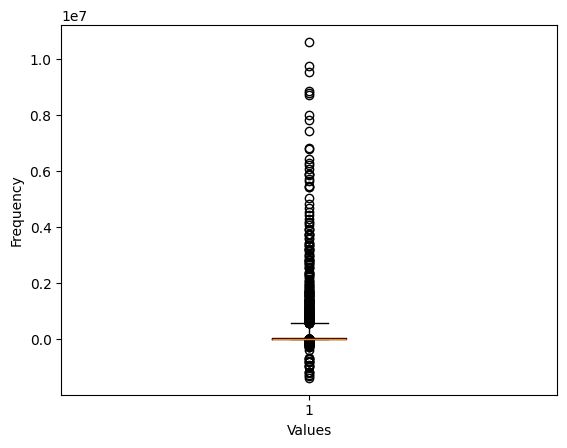

In [17]:
plt.boxplot(filtrado['Value'],  whis=[5, 95])

plt.xlabel('Values')
plt.ylabel('Frequency')

plt.show()

In [18]:
mean = np.mean(filtrado['Value'])
std = np.std(filtrado['Value'])

threshold = 3
outliers = []
for x in filtrado['Value']:
    z_score = (x - mean) / std
    if abs(z_score) > threshold:
        outliers.append(x)
print("Mean: ",mean)
print("\nStandard deviation: ",std)
print("\nOutliers  : ", outliers)

Mean:  134353.0043720191

Standard deviation:  631309.7002829097

Outliers  :  [2557150.0, 3230657.0, 3739612.0, 3721751.0, 4670137.0, 5449464.0, 2551125.0, 2827588.0, 2766813.0, 3446681.0, 4060293.0, 2048668.0, 2362932.0, 2736654.0, 2816739.0, 3431485.0, 3943384.0, 2257247.0, 2659778.0, 3172210.0, 5459724.0, 6213020.0, 6788703.0, 8779785.0, 9755678.0, 3569857.0, 5896164.0, 6827734.0, 7447468.0, 9539611.0, 10619006.0, 2967424.0, 3317929.0, 3763398.0, 4811318.0, 5041360.0, 3219271.0, 3942643.0, 4303409.0, 5445569.0, 5648849.0, 2228669.0, 4439990.0, 5868691.0, 5730577.0, 6309501.0, 7829518.0, 8853085.0, 2320042.0, 4527059.0, 5904975.0, 6090837.0, 6451399.0, 7992205.0, 8731155.0, 2149462.0, 2838360.0, 2824980.0, 3010150.0, 3716347.0, 4195461.0, 2358357.0, 3034038.0, 3134738.0, 3215078.0, 3894696.0, 4144833.0, 2069568.0, 2684363.0, 2715998.0, 2273468.0, 2589098.0, 3362302.0, 3593601.0, 2313425.0, 2405382.0, 2932976.0, 3372902.0, 2062090.0]


In [19]:
z_scores = np.abs((filtrado['Value'] - filtrado['Value'].mean()) / filtrado['Value'].std())

threshold = 3

outliers = filtrado[z_scores > threshold]

outliers

,Region/Country/Area,Country,Year,Series,System of trade,Value,Footnotes,Source
169,19,Americas,2005,Imports CIF (millions of US dollars),-,2557150.0,-,"United Nations Statistics Division, New York, ..."
170,19,Americas,2010,Imports CIF (millions of US dollars),-,3230657.0,-,"United Nations Statistics Division, New York, ..."
171,19,Americas,2015,Imports CIF (millions of US dollars),-,3739612.0,-,"United Nations Statistics Division, New York, ..."
172,19,Americas,2020,Imports CIF (millions of US dollars),-,3721751.0,-,"United Nations Statistics Division, New York, ..."
173,19,Americas,2021,Imports CIF (millions of US dollars),-,4670137.0,-,"United Nations Statistics Division, New York, ..."
...,...,...,...,...,...,...,...,...
4846,840,United States of America,2015,Imports CIF (millions of US dollars),G,2313425.0,-,"United Nations Statistics Division, New York, ..."
4847,840,United States of America,2020,Imports CIF (millions of US dollars),G,2405382.0,-,"United Nations Statistics Division, New York, ..."
4848,840,United States of America,2021,Imports CIF (millions of US dollars),G,2932976.0,-,"United Nations Statistics Division, New York, ..."
4849,840,United States of America,2022,Imports CIF (millions of US dollars),G,3372902.0,-,"United Nations Statistics Division, New York, ..."


## <font color='Red'>Câmbio Dólar e Real</font>

In [26]:
df_tempo = pd.read_csv('cambio_dollar_real.csv')
df_tempo['Date'] = pd.to_datetime(df_tempo['Date'])

In [27]:
df_tempo

,Date,Price,Open,High,Low,Vol.,Change %
0,2023-12-28,4.85,4.83,4.87,4.82,NaN,0.53%
1,2023-12-27,4.83,4.81,4.84,4.80,NaN,0.26%
2,2023-12-26,4.81,4.85,4.86,4.81,NaN,-0.92%
3,2023-12-22,4.86,4.89,4.89,4.85,NaN,-0.53%
4,2023-12-21,4.88,4.91,4.91,4.86,NaN,-0.65%
...,...,...,...,...,...,...,...
3641,2010-01-07,1.75,1.73,1.75,1.73,NaN,0.81%
3642,2010-01-06,1.73,1.73,1.74,1.72,NaN,0.09%
3643,2010-01-05,1.73,1.72,1.74,1.71,NaN,0.57%
3644,2010-01-04,1.72,1.73,1.73,1.72,NaN,-1.25%


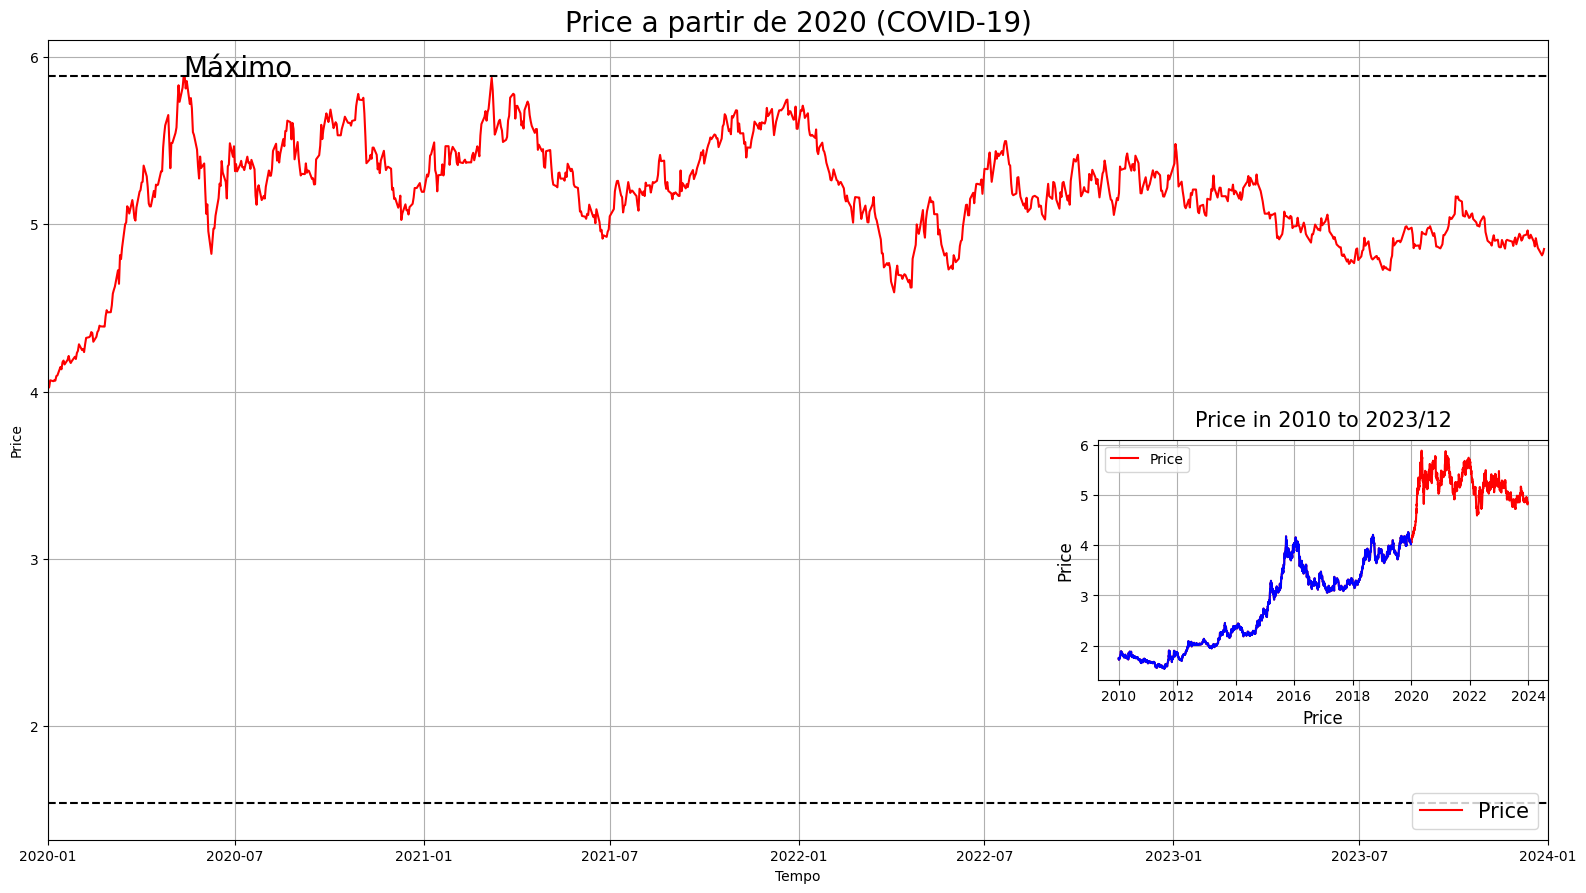

In [28]:
import datetime
fig = plt.figure(figsize=(15,8))

eixo = fig.add_axes([0, 0, 1, 1])
eixo2 = fig.add_axes([0.7,0.2,0.3,0.3])

eixo.plot(df_tempo['Date'], df_tempo['Price'], color ='red')
eixo2.plot(df_tempo['Date'], df_tempo['Price'], color ='red')

eixo2.set_title('Price in 2010 to 2023/12', fontsize= 15, pad=10)
eixo2.set_xlabel('Price', fontsize=12)
eixo2.set_ylabel('Price', fontsize=12)
eixo2.legend(['Price'], loc='best', fontsize=10)
eixo2.grid(True)

azul_esquerda= df_tempo['Date'] < datetime.datetime(2020,1,1)

eixo2.plot(df_tempo[azul_esquerda]['Date'],df_tempo[azul_esquerda]['Price'], color ='b')


eixo.set_xlim(datetime.datetime(2020,1,1), datetime.datetime(2024,1,1))
eixo.set_title('Price a partir de 2020 (COVID-19)', fontsize= 20)
eixo.set_xlabel('Tempo', fontsize=10)
eixo.set_ylabel('Price', fontsize=10)
eixo.legend(['Price'], loc='lower right', fontsize=15)

eixo.grid(True)

x1= df_tempo['Date'][df_tempo['Price'].idxmax()]
y1 = max(df_tempo['Price'])

eixo.annotate('Máximo', xy=(x1,y1), fontsize=20)


y=1.2

eixo.annotate('Mínimo', xy=(x1,y), fontsize=20)

eixo.axhline(max(df_tempo['Price']), color ='k', linestyle ='--')
eixo.axhline(min(df_tempo['Price']), color ='k', linestyle ='--')

## <font color='Red'>Commodities</font>

### <font color='Grey'>Formatação e Pré-processamento</font>


Baixando o banco de dados.

In [82]:
commodities = pd.read_csv('commodities.csv')
commodities_nominais = pd.read_csv('commodities_2010_2022.csv')

In [83]:
commodities_br = ['Brazil']
maskpais = commodities_nominais['Country or Area'].isin(commodities_br)
commodities_nominais_br = commodities_nominais[maskpais]
print(commodities_nominais_br)

        Country or Area  Year  \
11762            Brazil  2022   
11763            Brazil  2022   
11764            Brazil  2022   
11765            Brazil  2022   
11766            Brazil  2022   
...                 ...   ...   
7332323          Brazil  1993   
7332324          Brazil  1992   
7332325          Brazil  1991   
7332326          Brazil  1990   
7332327          Brazil  1989   

                                                 Commodity    Flow  \
11762             Horses; live, pure-bred breeding animals  Export   
11763             Horses; live, pure-bred breeding animals  Import   
11764    Horses; live, other than pure-bred breeding an...  Export   
11765    Horses; live, other than pure-bred breeding an...  Import   
11766                                          Asses; live  Export   
...                                                    ...     ...   
7332323        Commodities not specified according to kind  Export   
7332324        Commodities not specified ac

Removendo os NaN do banco para deixá-lo mais legível. Removendo a coluna 'System of trade footnote', que possui apenas dados de NaN.

In [84]:
commodities_nominais_br.head()

,Country or Area,Year,Commodity,Flow,Trade (USD),Weight (kg),Quantity Name,Quantity,code
11762,Brazil,2022,"Horses; live, pure-bred breeding animals",Export,4608118.00,83647.00,No Quantity,NaN,1
11763,Brazil,2022,"Horses; live, pure-bred breeding animals",Import,5776058.00,82110.00,Number of items,186.00,1
11764,Brazil,2022,"Horses; live, other than pure-bred breeding an...",Export,4214048.00,132206.64,No Quantity,NaN,1
11765,Brazil,2022,"Horses; live, other than pure-bred breeding an...",Import,3234706.00,49400.00,Number of items,104.00,1
11766,Brazil,2022,Asses; live,Export,12111.00,NaN,No Quantity,NaN,1


In [85]:
len(commodities_nominais_br['Commodity'].unique())
commodities_nominais_br.reset_index()


,index,Country or Area,Year,Commodity,Flow,Trade (USD),Weight (kg),Quantity Name,Quantity,code
0,11762,Brazil,2022,"Horses; live, pure-bred breeding animals",Export,4608118.00,83647.00,No Quantity,NaN,1
1,11763,Brazil,2022,"Horses; live, pure-bred breeding animals",Import,5776058.00,82110.00,Number of items,186.00,1
2,11764,Brazil,2022,"Horses; live, other than pure-bred breeding an...",Export,4214048.00,132206.64,No Quantity,NaN,1
3,11765,Brazil,2022,"Horses; live, other than pure-bred breeding an...",Import,3234706.00,49400.00,Number of items,104.00,1
4,11766,Brazil,2022,Asses; live,Export,12111.00,NaN,No Quantity,NaN,1
...,...,...,...,...,...,...,...,...,...,...
139635,7332323,Brazil,1993,Commodities not specified according to kind,Export,210444176.00,1135055360.00,Weight in kilograms,1135055360.00,99
139636,7332324,Brazil,1992,Commodities not specified according to kind,Export,296380992.00,1393634048.00,Weight in kilograms,1393634048.00,99
139637,7332325,Brazil,1991,Commodities not specified according to kind,Export,342005408.00,1322470144.00,Weight in kilograms,1322470144.00,99
139638,7332326,Brazil,1990,Commodities not specified according to kind,Export,379117856.00,1217710208.00,Weight in kilograms,1217710208.00,99


In [86]:
valor_commodities_br= commodities_nominais_br.query('Year >= 2012').groupby(['Commodity','Flow'])['Trade (USD)'].sum()
top_20_commodities_br = valor_commodities_br.sort_values(ascending=False).head(20)
pd.set_option('display.float_format', lambda x: '%.2f' % x)
df_top_20_commodities_br = pd.DataFrame(
    {
        'Commodity': [top_20_commodities_br.index[i][0] for i in range(0,20)],
        'Flow': [top_20_commodities_br.index[i][1] for i in range(0,20)],
        'Trade': top_20_commodities_br.values
        }
    )
df_top_20_commodities_br.reset_index()


print(df_top_20_commodities_br)


                                            Commodity    Flow           Trade
0   Soya beans; other than seed, whether or not br...  Export 302302362520.00
1        Iron ores and concentrates; non-agglomerated  Export 236047307022.00
2   Oils; petroleum oils and oils obtained from bi...  Export 230444816103.00
3   Petroleum oils and oils from bituminous minera...  Import  95295007661.00
4   Oils; petroleum oils and oils obtained from bi...  Import  86502234951.00
5   Sugars; cane sugar, raw, in solid form, other ...  Export  84368364528.00
6   Oil-cake and other solid residues; whether or ...  Export  72441659312.00
7   Wood pulp; chemical wood pulp, soda or sulphat...  Export  64576907604.00
8              Cereals; maize (corn), other than seed  Export  61742095102.00
9   Petroleum oils and oils from bituminous minera...  Import  60539323935.00
10               Coffee; not roasted or decaffeinated  Export  59565608622.00
11     Meat; of bovine animals, boneless cuts, frozen  Export  5

Faremos agora o tratamento dos dados relacionados aos anos da balança. São eles 1995,2005,2010,2015,2020,2021,2022

In [87]:
commodities_nominais_anos_balanca =commodities_nominais_br.query('Year == @years').groupby(['Commodity','Flow'])['Trade (USD)'].sum()
top_20_commodities_balanca_br = commodities_nominais_anos_balanca.sort_values(ascending=False).head(20)
pd.set_option('display.float_format', lambda x: '%.2f' % x)
df_top_20_commodities_balanca_br = pd.DataFrame(
    {
        'Commodity': [top_20_commodities_balanca_br.index[i][0] for i in range(0,20)],
        'Flow': [top_20_commodities_balanca_br.index[i][1] for i in range(0,20)],
        'Trade': top_20_commodities_balanca_br.values
        }
    )
df_top_20_commodities_balanca_br.reset_index()


print(df_top_20_commodities_balanca_br)

                                            Commodity    Flow           Trade
0   Soya beans; other than seed, whether or not br...  Export 134830393434.00
1        Iron ores and concentrates; non-agglomerated  Export 122367496935.00
2   Oils; petroleum oils and oils obtained from bi...  Export 120985679938.00
3   Petroleum oils and oils from bituminous minera...  Import  43951789985.00
4   Oils; petroleum oils and oils obtained from bi...  Import  34872606417.00
5                Coffee; not roasted or decaffeinated  Export  34511363994.00
6   Oil-cake and other solid residues; whether or ...  Export  34131037012.00
7      Meat; of bovine animals, boneless cuts, frozen  Export  33733226873.00
8   Wood pulp; chemical wood pulp, soda or sulphat...  Export  32611939907.00
9   Sugars; cane sugar, raw, in solid form, other ...  Export  30760749471.00
10             Cereals; maize (corn), other than seed  Export  29216202884.00
11  Petroleum oils and oils from bituminous minera...  Export  2

In [88]:
lista_10_anos = [2012,2013,2014,2015,2016,2017,2018,2019,2020,2021,2022]

mean_values = commodities.groupby(['Flow', 'Country or Area', 'Year'])['Trade (USD)'].mean()

top_countries = mean_values.groupby('Flow', group_keys=False).nlargest(14)
print(top_countries)

mean_values['Export']['USA'][lista_10_anos]

top_3_commodities_br_export = df_top_20_commodities_br.query("Flow == 'Export'").sort_values(by='Trade', ascending = False)
top_3_commodities_br_export = top_3_commodities_br_export.head(4)
top_3_commodities_br_export = pd.DataFrame(top_3_commodities_br_export)
top_3_commodities_br_export.reset_index
print(top_3_commodities_br_export)

top_3_commodities_br_import = df_top_20_commodities_br.query("Flow == 'Import'").sort_values(by='Trade', ascending = False)
top_3_commodities_br_import = pd.DataFrame(top_3_commodities_br_import)
top_3_commodities_br_import.reset_index
print(top_3_commodities_br_import)


                                           Commodity    Flow           Trade
0  Soya beans; other than seed, whether or not br...  Export 302302362520.00
1       Iron ores and concentrates; non-agglomerated  Export 236047307022.00
2  Oils; petroleum oils and oils obtained from bi...  Export 230444816103.00
5  Sugars; cane sugar, raw, in solid form, other ...  Export  84368364528.00
                                            Commodity    Flow          Trade
3   Petroleum oils and oils from bituminous minera...  Import 95295007661.00
4   Oils; petroleum oils and oils obtained from bi...  Import 86502234951.00
9   Petroleum oils and oils from bituminous minera...  Import 60539323935.00
15  Fertilizers, mineral or chemical; potassic, po...  Import 41673733152.00
17  Coal; bituminous, whether or not pulverised, b...  Import 29467382562.00
19  Medicaments; consisting of mixed or unmixed pr...  Import 28530426368.00


Faremos agora o tratamento dos dados relacionados aos anos da balança. São eles 1995,2005,2010,2015,2020,2021,2022


In [89]:
top_3_commodities_br_balanca_export = df_top_20_commodities_balanca_br.query("Flow == 'Export'").sort_values(by='Trade', ascending = False)
top_3_commodities_br_balanca_export = top_3_commodities_br_balanca_export.head(4)
top_3_commodities_br_balanca_export = pd.DataFrame(top_3_commodities_br_balanca_export)
top_3_commodities_br_balanca_export.reset_index
print(top_3_commodities_br_balanca_export)

top_3_commodities_br_balanca_import = df_top_20_commodities_balanca_br.query("Flow == 'Import'").sort_values(by='Trade', ascending = False)
top_3_commodities_br_balanca_import = pd.DataFrame(top_3_commodities_br_balanca_import)
top_3_commodities_br_balanca_import.reset_index
print(top_3_commodities_br_balanca_import)

                                           Commodity    Flow           Trade
0  Soya beans; other than seed, whether or not br...  Export 134830393434.00
1       Iron ores and concentrates; non-agglomerated  Export 122367496935.00
2  Oils; petroleum oils and oils obtained from bi...  Export 120985679938.00
5               Coffee; not roasted or decaffeinated  Export  34511363994.00
                                            Commodity    Flow          Trade
3   Petroleum oils and oils from bituminous minera...  Import 43951789985.00
4   Oils; petroleum oils and oils obtained from bi...  Import 34872606417.00
13  Fertilizers, mineral or chemical; potassic, po...  Import 21937205006.00
15  Petroleum oils and oils from bituminous minera...  Import 19248246412.00
18  Coal; bituminous, whether or not pulverised, b...  Import 14440535941.00
19  Medicaments; consisting of mixed or unmixed pr...  Import 12907064537.00


### <font color='Grey'>Outliers</font>

In [90]:
is_all_na = commodities['Weight (kg)'].isna().all()

print(is_all_na)

True


In [91]:
is_all_na = commodities['Quantity'].isna().all()

print(is_all_na)

True


In [92]:
tabela = pd.DataFrame({'Ano': commodities['Quantity Name'].value_counts().index, 'Frequência': commodities['Quantity Name'].value_counts().values}) ; print(tabela)

           Ano  Frequência
0  No Quantity       11180


In [93]:
commodities = commodities.drop('Weight (kg)', axis=1)

commodities = commodities.drop('Quantity Name', axis=1)

commodities = commodities.drop('Quantity', axis=1)


In [94]:
commodities

,Country or Area,Year,Commodity,Flow,Trade (USD)
0,Afghanistan,2019,All Commodities,Export,870488512.46
1,Afghanistan,2019,All Commodities,Import,8568013876.87
2,Afghanistan,2019,All Commodities,Re-Export,6655196.71
3,Afghanistan,2018,All Commodities,Import,7406590324.75
4,Afghanistan,2018,All Commodities,Re-Export,9263097.24
...,...,...,...,...,...
11175,Zimbabwe,2000,All Commodities,Re-Export,32029403.32
11176,Zimbabwe,2000,All Commodities,Export,1607052525.67
11177,Zimbabwe,2000,All Commodities,Import,2016521465.45
11178,Zimbabwe,1995,All Commodities,Import,2658853376.00


In [95]:
mean_values = commodities.groupby('Country or Area')['Trade (USD)'].mean()

top_countries = mean_values.sort_values(ascending=False).head(17)
pd.set_option('display.float_format', lambda x: '%.2f' % x)
print(top_countries)

Country or Area
EU-28                      1861576769662.78
China                      1174514467583.53
ASEAN                      1021004726964.64
USA                         978161750820.90
Germany                     937364729838.25
Japan                       532263252997.09
France                      475899136241.16
United Kingdom              403345820506.01
Netherlands                 371135133559.10
China, Hong Kong SAR        350746653647.29
Fmr Fed. Rep. of Germany    320838050500.00
Belgium                     315355412049.95
Rep. of Korea               308127079506.79
Italy                       297347761575.80
Canada                      254159955630.50
Mexico                      251876693737.42
Singapore                   236428777794.82
Name: Trade (USD), dtype: float64


### Total em porcentagem do top 3 importações de commodities dos nos ultimos 10 anos dos all commodities

In [126]:

top_3_import_total = top_3_commodities_br_import['Trade'][:3].sum()
import_10anos_total = mean_values['Import']['Brazil'][lista_10_anos].values.sum()
print(top_3_import_total/import_10anos_total*100)


10.539201560523036


In [127]:
top_3_import_balanca_total = top_3_commodities_br_balanca_import['Trade'][:3].sum()
balanca_years_impo_allcommodities =  mean_values['Import']['Brazil'][years].values.sum()

print(top_3_import_balanca_total/df_soma_expo_impo_balanca_br['importação'] *100)
print('usando o banco de dados dos all commodities temos:', top_3_import_balanca_total/balanca_years_impo_allcommodities*100)

0   8.58
Name: importação, dtype: float64
usando o banco de dados dos all commodities temos: 8.400659640484596


Total em porcentagem do top 3 exportações de commodities nos ultimos 10 anos dos all commodities 

In [128]:

top_3_export_total = top_3_commodities_br_export['Trade'][:3].sum()
export_10anos_total = mean_values['Export']['Brazil'][lista_10_anos].values.sum()

print(top_3_export_total/export_10anos_total*100)


30.12304712505283


In [129]:
top_3_export_balanca_total = top_3_commodities_br_balanca_export['Trade'][:3].sum()
balanca_years_expo_allcommodities =  mean_values['Export']['Brazil'][years].values.sum()

print(top_3_export_balanca_total/df_soma_expo_impo_balanca_br['exportação'] *100)
print('usando o banco de dados dos all commodities temos:',top_3_export_balanca_total/balanca_years_expo_allcommodities*100)

0   27.35
Name: exportação, dtype: float64
usando o banco de dados dos all commodities temos: 27.46902372922653


Country or Area
USA       93903528078806.00
EU-28     85632531404487.81
China     72819896990179.00
Germany   59991342709648.29
Name: Trade (USD), dtype: float64
De 1988 ao ano de 2022 foram negociados em commodities 
pelo mundo aproximadamente 877905545939580.2 dolares



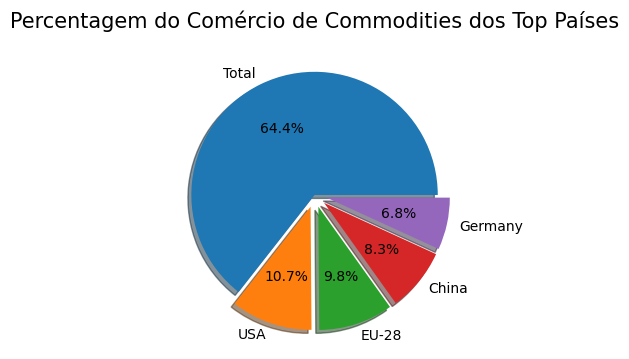

In [130]:

mean_values = commodities.groupby('Country or Area')['Trade (USD)'].sum()



top_countries = mean_values.sort_values(ascending=False).head(4)
pd.set_option('display.float_format', lambda x: '%.2f' % x)
print(top_countries)


soma_anos = np.sum(total_values_ano)
print('De 1988 ao ano de 2022 foram negociados em commodities \npelo mundo aproximadamente',soma_anos, 'dolares\n')


# Calculando a porcentagem para os top países
percentages = (top_countries / soma_anos) * 100

# Criar uma figura e um eixo
fig, ax = plt.subplots(figsize=(5, 4))

# Montar os dados para o gráfico de pizza
labels = ['Total'] + top_countries.index.tolist()
sizes = [100 - sum(percentages)] + percentages.tolist()
explodir=[0,0.1,0.1,0.1,0.1]
# Adicionar o gráfico de pizza
ax.pie(sizes, labels=labels, autopct='%1.1f%%', shadow=True, explode=explodir)

# Adicionar título
ax.set_title('Percentagem do Comércio de Commodities dos Top Países', fontsize=15, pad=10)

# Mostrar o gráfico
plt.show()


In [131]:
mean_values = filtrado.groupby('Country')['Value'].mean()

top_countries = mean_values.sort_values(ascending=False).head(4)
pd.set_option('display.float_format', lambda x: '%.2f' % x)
print(top_countries)

Country
Asia             4329259.52
Europe           4001683.05
Eastern Asia     2418306.29
Western Europe   2005516.62
Name: Value, dtype: float64


In [132]:
mean_values = filtrado.groupby('Country')['Value'].mean()

top_countries = mean_values.sort_values(ascending=False).head(17)
pd.set_option('display.float_format', lambda x: '%.2f' % x)
print(top_countries)

Country
Asia                            4329259.52
Europe                          4001683.05
Eastern Asia                    2418306.29
Western Europe                  2005516.62
Americas                        1760527.05
China                           1362552.67
Northern America                1176603.81
United States of America         905974.29
Germany                          836065.43
South-eastern Asia               787894.52
Northern Europe                  707531.62
Eastern Europe                   679063.29
Western Asia                     643711.90
Southern Europe                  609571.52
Latin America & the Caribbean    583923.24
Japan                            435956.71
Netherlands (Kingdom of the)     333649.05
Name: Value, dtype: float64


In [133]:
mean_values = filtrado.groupby(['Series', 'Country'])['Value'].mean()

top_countries = mean_values.groupby('Series', group_keys=False).nlargest(14)

print(top_countries)

Series                                            Country                      
Balance imports/exports (millions of US dollars)  Asia                             541096.14
                                                  China                            424286.14
                                                  Eastern Asia                     420317.00
                                                  Germany                          177301.29
                                                  Russian Federation               168757.71
                                                  Western Asia                     164603.71
                                                  Western Europe                   161118.86
                                                  Eastern Europe                   135537.57
                                                  Europe                           108234.43
                                                  Saudi Arabia                     

In [134]:
mean_values = filtrado.groupby(['System of trade', 'Country'])['Value'].mean()

top_countries = mean_values.groupby('System of trade', group_keys=False).nlargest(14)

print(top_countries)

System of trade  Country                      
-                Asia                            4329259.52
                 Europe                          4001683.05
                 Eastern Asia                    2418306.29
                 Western Europe                  2005516.62
                 Americas                        1760527.05
                 Northern America                1176603.81
                 South-eastern Asia               787894.52
                 Northern Europe                  707531.62
                 Eastern Europe                   679063.29
                 Western Asia                     643711.90
                 Southern Europe                  609571.52
                 Latin America & the Caribbean    583923.24
                 South America                    309027.90
                 Africa                           278352.48
G                China                           1362552.67
                 United States of America         905

In [135]:
filtrado2 = filtrado[filtrado['Year'] == 2022]
mean_values = filtrado2.groupby('Country')['Value'].mean()

top_countries = mean_values.sort_values(ascending=False).head(20)
pd.set_option('display.float_format', lambda x: '%.2f' % x)
print(top_countries)

Country
Asia                            7079337.33
Europe                          5820770.33
Eastern Asia                    3765899.33
Western Europe                  2763222.00
Americas                        2706862.00
China                           2395734.33
Northern America                1773185.67
United States of America        1374726.67
South-eastern Asia              1305212.00
Western Asia                    1220994.33
Germany                         1110424.00
Eastern Europe                  1096313.33
Northern Europe                 1026601.00
Southern Europe                  934634.00
Latin America & the Caribbean    933676.00
Netherlands (Kingdom of the)     513538.00
Japan                            497781.33
South America                    488820.00
Italy                            466876.67
Republic of Korea                455730.67
Name: Value, dtype: float64


In [136]:
geolocator = Nominatim(user_agent="my_geocoder")

countries = ['China', 'United States of America', 'Germany', 'Netherlands']

map_center = [0, 0]
zoom_level = 2

mymap = folium.Map(location=map_center, zoom_start=zoom_level)

for country in countries:
    location = geolocator.geocode(country)
    if location:
        folium.Marker(
            location=[location.latitude, location.longitude],
            popup=country
        ).add_to(mymap)

mymap.save("world_map.html")

mymap


In [137]:
commodities2 = commodities[commodities['Year'] == 2022]
mean_values = commodities2.groupby('Country or Area')['Trade (USD)'].mean()

top_countries = mean_values.sort_values(ascending=False).head(14)
pd.set_option('display.float_format', lambda x: '%.2f' % x)
print(top_countries)

Country or Area
China                  3154799476431.50
EU-28                  2932755795276.64
USA                    1917757027815.00
Germany                1621599630928.63
ASEAN                  1495187571037.41
Japan                   822635995177.89
Netherlands             741554259913.68
France                  718848147346.15
Rep. of Korea           707456172799.50
China, Hong Kong SAR    639310701716.54
India                   592625103519.84
Mexico                  591448118461.50
Singapore               495189500575.85
Italy                   486855702101.62
Name: Trade (USD), dtype: float64


In [138]:
geolocator = Nominatim(user_agent="my_geocoder")

countries = ['China', 'United States of America', 'Germany', 'Japan']

map_center = [0, 0]
zoom_level = 2

mymap = folium.Map(location=map_center, zoom_start=zoom_level)

for country in countries:
    location = geolocator.geocode(country)
    if location:
        folium.Marker(
            location=[location.latitude, location.longitude],
            popup=country
        ).add_to(mymap)

mymap.save("world_map.html")

mymap

Observando se há a presença de outliers.

As duas primeiras colunas são basicamente as mesmas. Dessa forma, observar se elas possuem o mesmo número de linhas é interessante.

In [139]:
paises = commodities['Country or Area'].unique()

nomes = pd.Series(paises)
nomes_unicos = nomes.str.lower().unique()

print(nomes_unicos)

['afghanistan' 'albania' 'algeria' 'andorra' 'angola' 'anguilla'
 'antigua and barbuda' 'argentina' 'armenia' 'aruba' 'asean' 'australia'
 'austria' 'azerbaijan' 'bahamas' 'bahrain' 'bangladesh' 'barbados'
 'belarus' 'belgium' 'belgium-luxembourg' 'belize' 'benin' 'bermuda'
 'bhutan' 'bolivia (plurinational state of)' 'bosnia herzegovina'
 'botswana' 'brazil' 'brunei darussalam' 'bulgaria' 'burkina faso'
 'burundi' 'cabo verde' 'cambodia' 'cameroon' 'canada' 'cayman isds'
 'central african rep.' 'chad' 'chile' 'china' 'china, hong kong sar'
 'china, macao sar' 'colombia' 'comoros' 'congo' 'cook isds' 'costa rica'
 "côte d'ivoire" 'croatia' 'cuba' 'cyprus' 'czech rep.'
 'dem. rep. of the congo' 'denmark' 'djibouti' 'dominica' 'dominican rep.'
 'ecuador' 'egypt' 'el salvador' 'eritrea' 'estonia' 'ethiopia' 'eu-28'
 'faeroe isds' 'fiji' 'finland' 'fmr fed. rep. of germany' 'fmr sudan'
 'france' 'french guiana' 'french polynesia' 'fs micronesia' 'gabon'
 'gambia' 'georgia' 'germany' 'ghana

Observando se os anos estão dentro do esperado.

In [140]:
commodities['Year'].value_counts().values

array([417, 412, 412, 410, 408, 408, 407, 407, 404, 403, 403, 403, 401,
       401, 397, 393, 387, 382, 381, 378, 366, 356, 321, 297, 297, 276,
       258, 257, 218, 157, 125,  90,  68,  56,  24], dtype=int64)

In [141]:
commodities['Year'].value_counts().index

Index([2010, 2012, 2011, 2009, 2015, 2013, 2007, 2014, 2008, 2004, 2016, 2017,
       2006, 2005, 2003, 2018, 2002, 2000, 2001, 2019, 2020, 2021, 1999, 1998,
       1997, 1996, 1995, 2022, 1994, 1993, 1992, 1991, 1990, 1989, 1988],
      dtype='int64', name='Year')

       Fluxo  Frequência
0     Import        4847
1     Export        4828
2  Re-Export        1505


[Text(0, 0, '1988'),
 Text(1, 0, '1989'),
 Text(2, 0, '1990'),
 Text(3, 0, '1991'),
 Text(4, 0, '1992'),
 Text(5, 0, '1993'),
 Text(6, 0, '1994'),
 Text(7, 0, '1995'),
 Text(8, 0, '1996'),
 Text(9, 0, '1997'),
 Text(10, 0, '1998'),
 Text(11, 0, '1999'),
 Text(12, 0, '2000'),
 Text(13, 0, '2001'),
 Text(14, 0, '2002'),
 Text(15, 0, '2003'),
 Text(16, 0, '2004'),
 Text(17, 0, '2005'),
 Text(18, 0, '2006'),
 Text(19, 0, '2007'),
 Text(20, 0, '2008'),
 Text(21, 0, '2009'),
 Text(22, 0, '2010'),
 Text(23, 0, '2011'),
 Text(24, 0, '2012'),
 Text(25, 0, '2013'),
 Text(26, 0, '2014'),
 Text(27, 0, '2015'),
 Text(28, 0, '2016'),
 Text(29, 0, '2017'),
 Text(30, 0, '2018'),
 Text(31, 0, '2019'),
 Text(32, 0, '2020'),
 Text(33, 0, '2021'),
 Text(34, 0, '2022')]

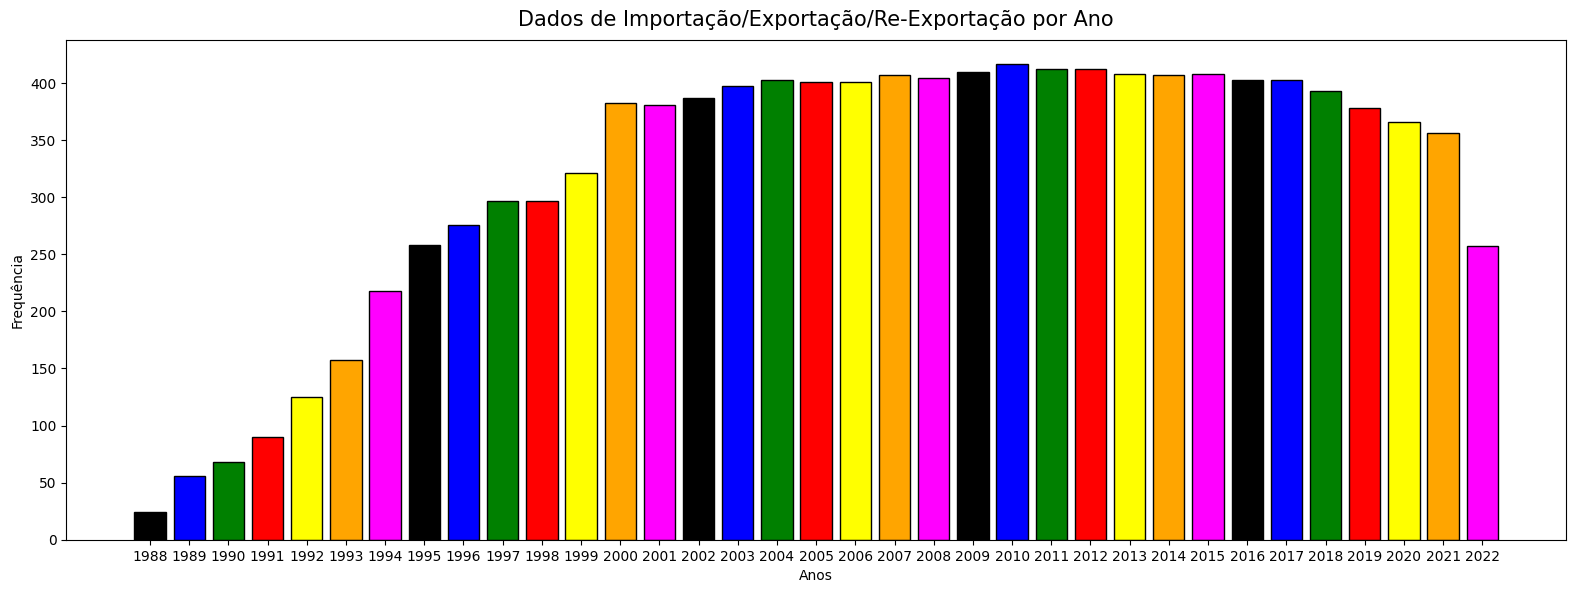

In [142]:
tabela_frequencia = pd.DataFrame({'Ano': commodities['Year'].value_counts().index, 'Frequência': commodities['Year'].value_counts().values}).sort_values(by='Ano',ascending=True) ; print(tabela)


fig = plt.figure(figsize=(15,5))
eixo = fig.add_axes([0,0,1,1])
cores=['k','b','g','r','yellow','orange','magenta']
indice =range(len(tabela_frequencia.Ano))
eixo.bar(indice, tabela_frequencia.Frequência, color=cores, edgecolor='black')
eixo.set_title('Dados de Importação/Exportação/Re-Exportação por Ano', fontsize=15, pad=10)
eixo.set_xlabel('Anos', fontsize=10)
eixo.set_ylabel('Frequência',fontsize=10)
eixo.set_xticks(indice)
eixo.set_xticklabels(tabela_frequencia.Ano)


In [143]:
tabela = pd.DataFrame({'Commodities': commodities['Commodity'].value_counts().index, 'Frequência': commodities['Commodity'].value_counts().values}) ; print(tabela)

       Commodities  Frequência
0  All Commodities       11180


       Fluxo  Frequência
0     Import        4847
1     Export        4828
2  Re-Export        1505


Text(0.5, 1.0, 'Tabela de Fluxos')

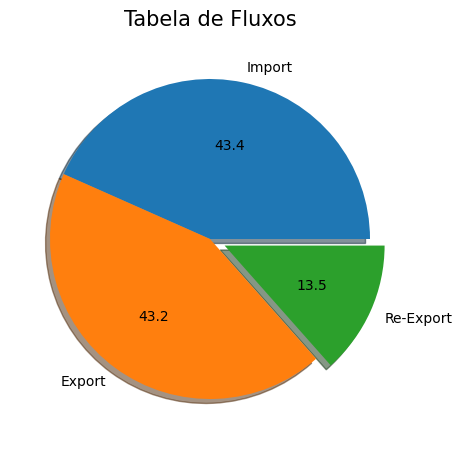

In [144]:
tabela = pd.DataFrame({'Fluxo': commodities['Flow'].value_counts().index, 'Frequência': commodities['Flow'].value_counts().values}) ; print(tabela)

fig = plt.figure(figsize=(5,4))
eixo = fig.add_axes([0,0,1,1])
explodir =[0,0,0.1]
eixo.pie(tabela.Frequência, labels=tabela.Fluxo,
         autopct='%.1f', explode = explodir, shadow=True)
eixo.set_title('Tabela de Fluxos', fontsize=15,pad=10)

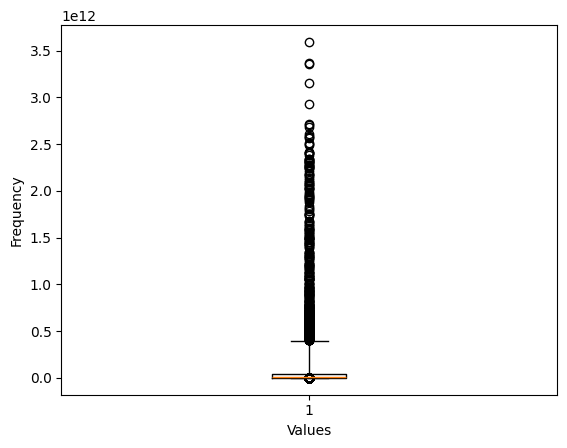

In [145]:
plt.boxplot(commodities['Trade (USD)'],  whis=[5, 95])

plt.xlabel('Values')
plt.ylabel('Frequency')

plt.show()

In [146]:
mean = np.mean(commodities['Trade (USD)'])
std = np.std(commodities['Trade (USD)'])

threshold = 3
outliers = []
for x in commodities['Trade (USD)']:
    z_score = (x - mean) / std
    if abs(z_score) > threshold:
        outliers.append(x)
print("Mean: ",mean)
print("\nStandard deviation: ",std)
print("\nOutliers  : ", outliers)

Mean:  78524646327.33276

Standard deviation:  244057541897.9814

Outliers  :  [1512702497024.39, 1477672645050.43, 1286877417017.09, 1342129537125.71, 1096596826525.52, 999702455974.99, 1092123785564.91, 1091514949607.75, 1084513677293.3, 1089950445396.2, 1012892811758.42, 969176527811.363, 846065124061.802, 875909029811.465, 884626203938.15, 852779416010.06, 963214538183.11, 963772828095.37, 975422743481.079, 939801632482.15, 945179751267.698, 929682907679.986, 926170815174.688, 889135744213.684, 3593601435602.0, 2715997517261.0, 2684362678517.0, 3362301613439.0, 2589098353298.0, 2069567864872.0, 2079285499197.0, 2499206993866.0, 2486439719803.0, 2133605397056.0, 1843792938795.0, 2263370504301.0, 1587920688162.0, 2097637171895.0, 1679564324560.0, 2273468224113.0, 2342292696320.0, 1959234625162.0, 2209007280259.0, 1949992314705.0, 2048782233084.0, 1818199227571.0, 1898388434783.0, 1743394866363.0, 1577763750888.0, 1396001565258.0, 1201646758080.0, 1005555225206.0, 1430693066080.0, 113

In [147]:
z_scores = np.abs((commodities['Trade (USD)'] - commodities['Trade (USD)'].mean()) / commodities['Trade (USD)'].std())

threshold = 3

outliers = commodities[z_scores > threshold]

outliers

,Country or Area,Year,Commodity,Flow,Trade (USD)
464,ASEAN,2022,All Commodities,Export,1512702497024.39
465,ASEAN,2022,All Commodities,Import,1477672645050.43
466,ASEAN,2021,All Commodities,Import,1286877417017.09
467,ASEAN,2021,All Commodities,Export,1342129537125.71
468,ASEAN,2020,All Commodities,Export,1096596826525.52
...,...,...,...,...,...
10839,USA,2000,All Commodities,Import,1217932974446.00
10842,USA,1999,All Commodities,Import,1059220066421.00
10845,USA,1998,All Commodities,Import,944350087088.00
10848,USA,1997,All Commodities,Import,898025469114.00


In [108]:
import plotly.express as px

def interactive_plot(dataframe, year, flow):

    filtered_df = dataframe[(dataframe['Year'] == year) & (dataframe['Flow'] == flow)]

    top_countries = filtered_df.sort_values('Trade (USD)', ascending=False).head(5)

    fig = px.bar(top_countries, x='Country or Area', y='Trade (USD)',
                 title=f"Top 5 Países com maior Trade em {year} ({flow})",
                 labels={'Trade (USD)': 'Trade em USD', 'Country or Area': 'País/Area'})
    fig.show()

interactive_plot(commodities, 2000, 'Export')

### <font color='Grey'>Maiores parceiros</font>

Valores de negociações a cada ano: 
 Year
1988    1457552510977.00
1989    2313030691540.00
1990    2728377597386.00
1991    3911766302419.00
1992    4954248189703.00
1993    5837576358235.00
1994    7727150798459.00
1995    9608180328445.00
1996   10278926768667.00
1997   10830185075332.00
1998   10821282170749.00
1999   11293559122850.00
2000   14732313365449.12
2001   14242519514834.12
2002   14973203612900.31
2003   17506572366911.44
2004   21247293807617.98
2005   23961976601116.21
2006   27821742210856.75
2007   31934469503028.69
2008   36869015789710.67
2009   28622351015697.86
2010   35973759360594.70
2011   43340408512084.70
2012   43114078647932.74
2013   44445174054449.82
2014   44386322475318.48
2015   38953812737872.10
2016   37971088972444.59
2017   41409327349035.59
2018   45564984812175.64
2019   44291148681209.39
2020   41088795464902.26
2021   51707231123915.20
2022   51986120044759.94
Name: Trade (USD), dtype: float64 

De 1988 ao ano de 2022 foram negociados em comm

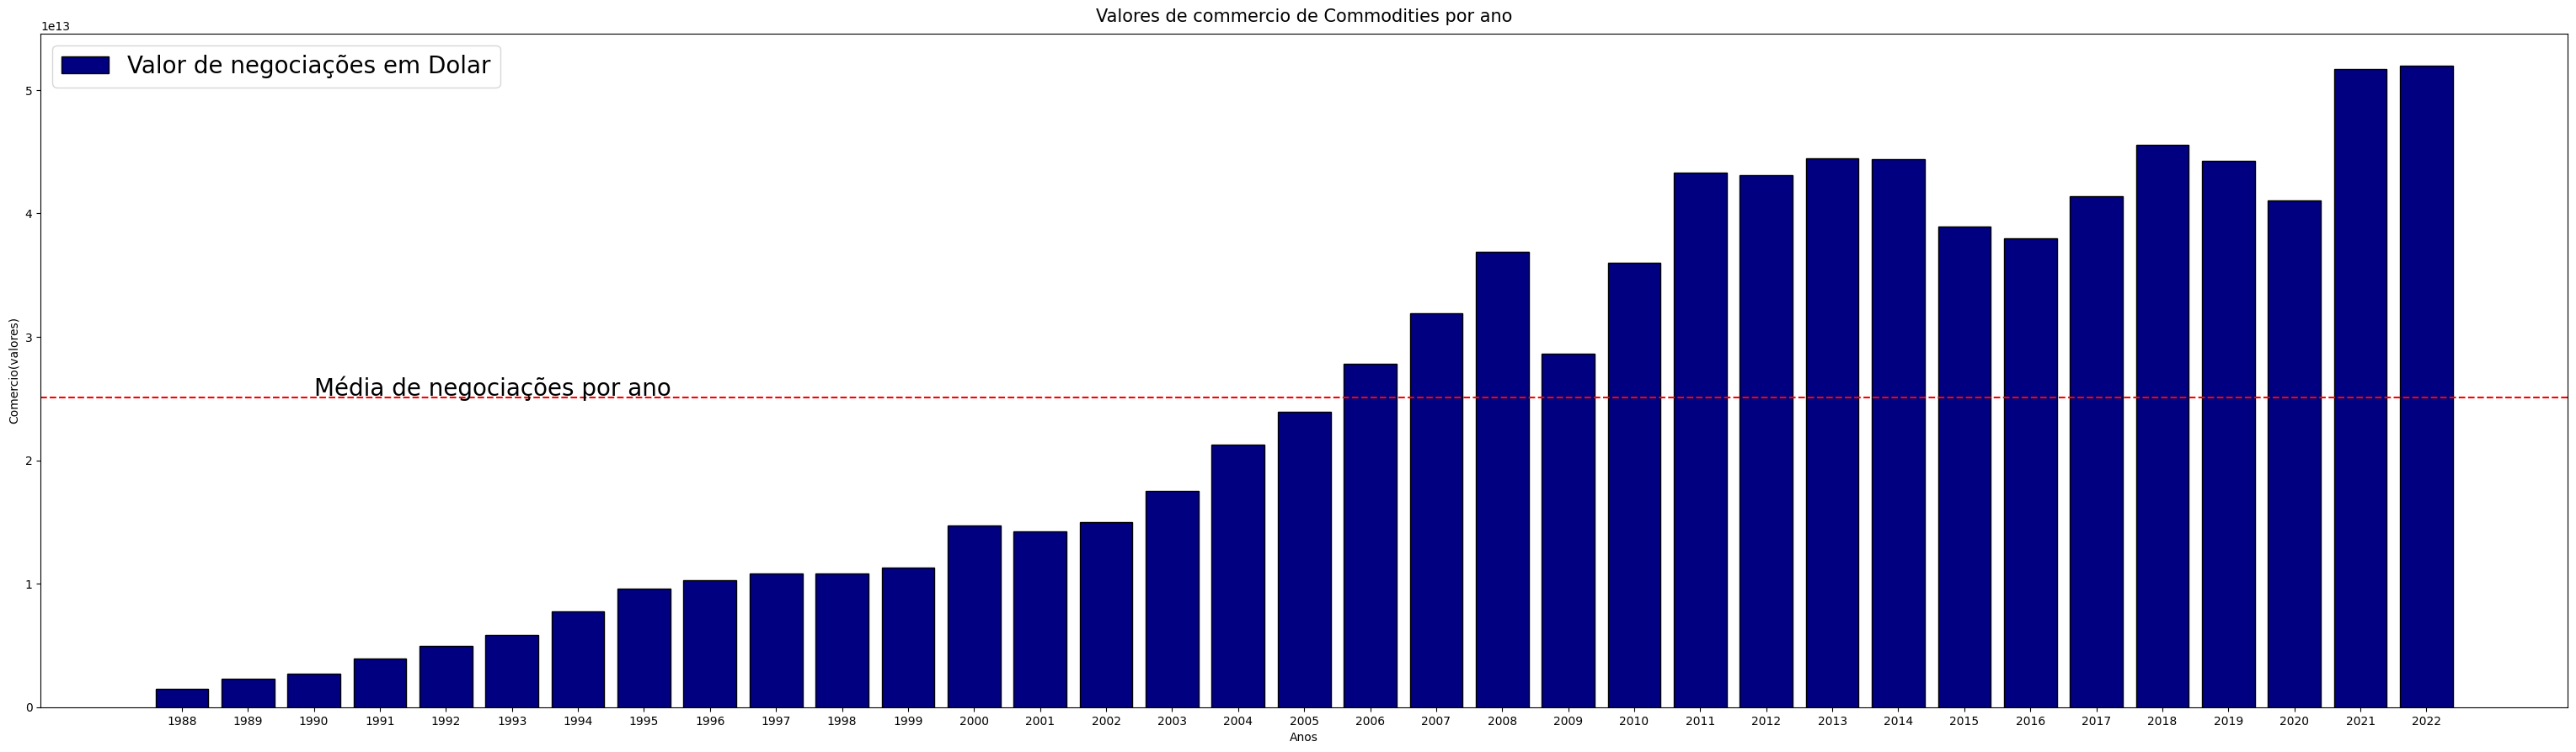

In [148]:


total_values_ano = commodities.groupby('Year')['Trade (USD)'].sum()
print('Valores de negociações a cada ano: \n',total_values_ano, '\n')

tam = (commodities['Year'].unique())
tam.sort()


soma_anos = np.sum(total_values_ano)
print('De 1988 ao ano de 2022 foram negociados em commodities \npelo mundo aproximadamente',soma_anos, 'dolares\n')

anos = len ((commodities['Year'].unique()))

media_soma_total = soma_anos/anos
print('A média de negociações nesses ultimos 35 anos foi\n de ',media_soma_total,' dolares')

fig = plt.figure(figsize=(30,8))
eixo = fig.add_axes([0,0,1,1])


eixo.bar(tam, total_values_ano, color='navy', edgecolor='black')
eixo.set_title('Valores de commercio de Commodities por ano', fontsize=15, pad=10)
eixo.set_xlabel('Anos', fontsize=10)
eixo.set_ylabel('Comercio(valores)',fontsize=10)
eixo.set_xticks(tam)
eixo.set_xticklabels(tam)
eixo.legend(['Valor de negociações em Dolar'], loc='best', fontsize=20)

meio_y = (max(total_values_ano) + min(total_values_ano)) / 2 -1500000000000
eixo.annotate('Média de negociações por ano', xy=(1990, meio_y), xytext=(1990, meio_y), fontsize=20)

eixo.axhline(media_soma_total, color ='red', linestyle ='--')

In [110]:
total_values_corrigido = (total_values_ano.values/tabela_frequencia.Frequência.values)

print(total_values_corrigido)


[6.07313546e+10 4.13041195e+10 4.01232000e+10 4.34640700e+10
 3.96339855e+10 3.71820150e+10 3.54456459e+10 3.72410090e+10
 3.72424883e+10 3.64652696e+10 3.64352935e+10 3.51824272e+10
 3.85662654e+10 3.73819410e+10 3.86904486e+10 4.40971596e+10
 5.27228134e+10 5.97555526e+10 6.93809033e+10 7.84630700e+10
 9.12599401e+10 6.98106122e+10 8.62680081e+10 1.05195166e+11
 1.04645822e+11 1.08934250e+11 1.09057303e+11 9.54750312e+10
 9.42210644e+10 1.02752673e+11 1.15941437e+11 1.17172351e+11
 1.12264468e+11 1.45245031e+11 2.02280623e+11]


Grafico corrigido pelo numero de entradas por ano.


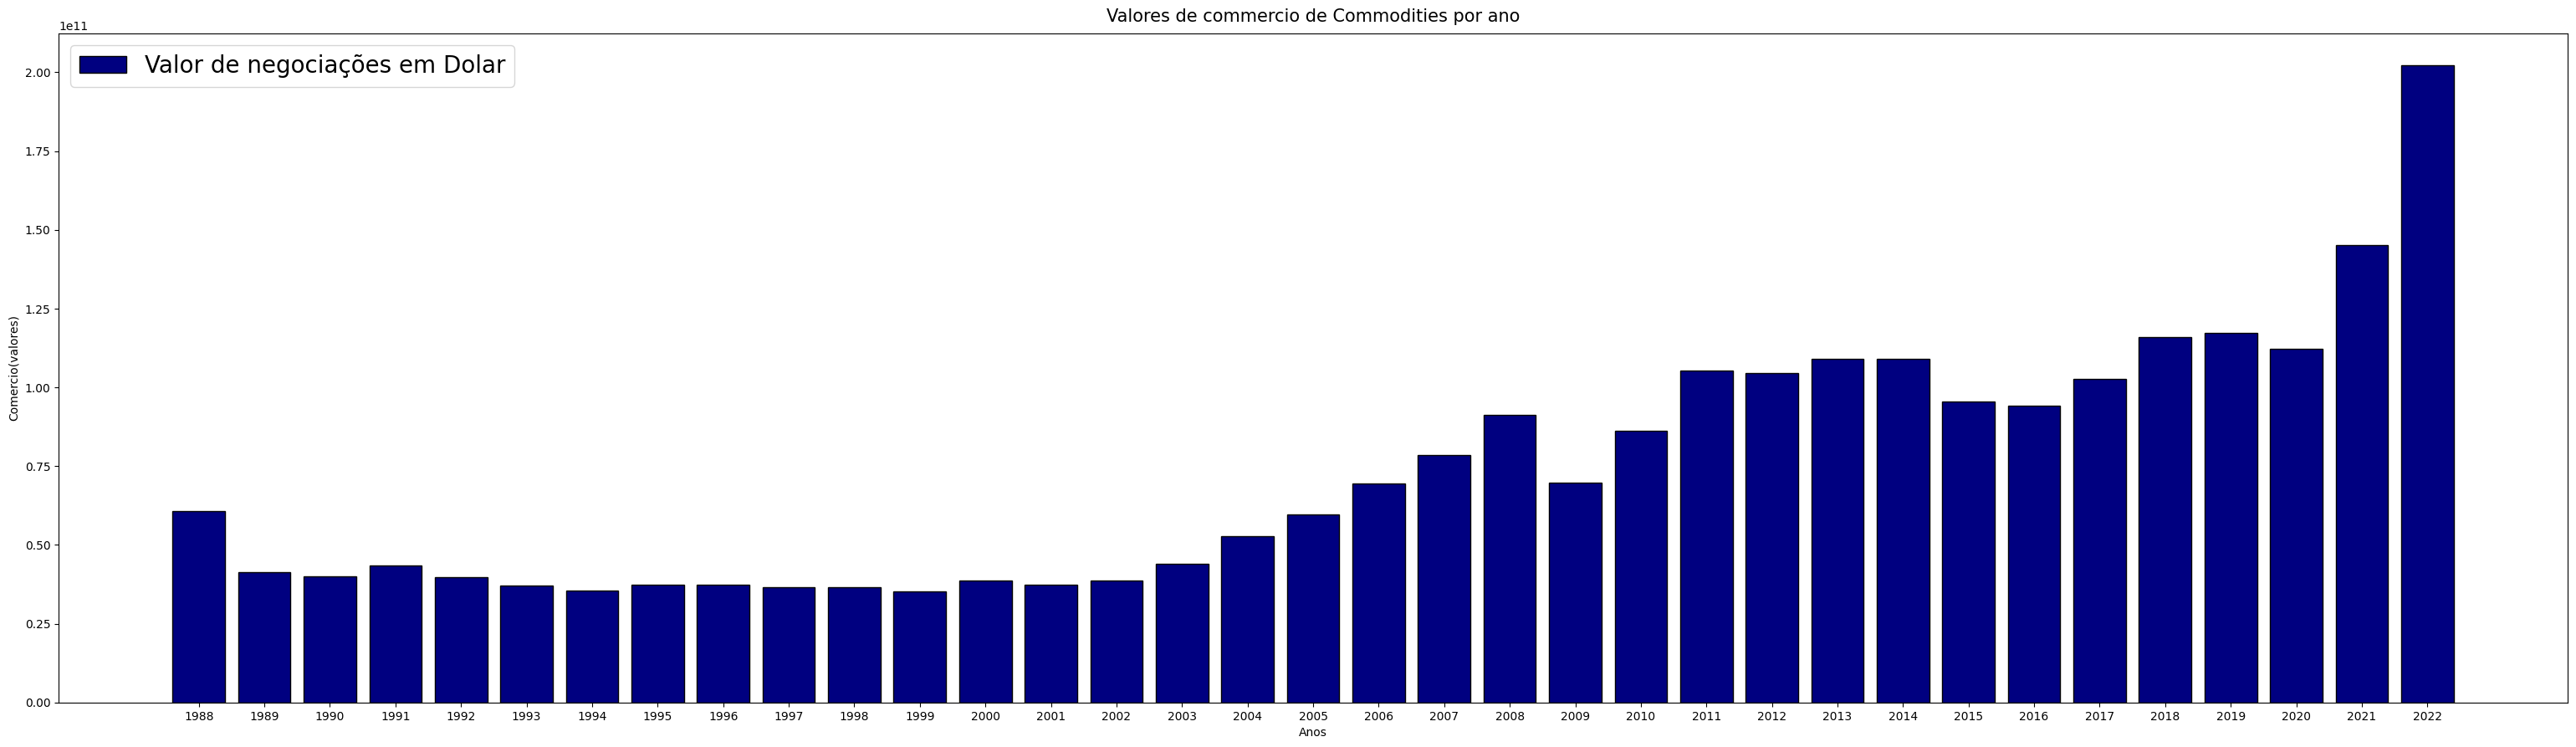

In [111]:

tam = (commodities['Year'].unique())
tam.sort()


fig = plt.figure(figsize=(30,8))
eixo = fig.add_axes([0,0,1,1])


eixo.bar(tam, total_values_corrigido, color='navy', edgecolor='black')
eixo.set_title('Valores de commercio de Commodities por ano', fontsize=15, pad=10)
eixo.set_xlabel('Anos', fontsize=10)
eixo.set_ylabel('Comercio(valores)',fontsize=10)
eixo.set_xticks(tam)
eixo.set_xticklabels(tam)
eixo.legend(['Valor de negociações em Dolar'], loc='best', fontsize=20)


In [112]:
df_total_values_corrigido = pd.DataFrame(
    {
        'Anos' : tam,
        'Valores negociados' : total_values_corrigido 
    }
)
df_total_values_corrigido



,Anos,Valores negociados
0,1988,60731354624.04
1,1989,41304119491.79
2,1990,40123199961.56
3,1991,43464070026.88
4,1992,39633985517.62
5,1993,37182015020.61
6,1994,35445645864.49
7,1995,37241009024.98
8,1996,37242488292.27
9,1997,36465269613.91


In [113]:
df_total_values_corrigido['aumento'] = df_total_values_corrigido['Valores negociados'].diff()
df_total_values_corrigido['aceleracao'] = df_total_values_corrigido['aumento'].diff()
df_total_values_corrigido.head()

,Anos,Valores negociados,aumento,aceleracao
0,1988,60731354624.04,NaN,NaN
1,1989,41304119491.79,-19427235132.26,NaN
2,1990,40123199961.56,-1180919530.23,18246315602.03
3,1991,43464070026.88,3340870065.32,4521789595.55
4,1992,39633985517.62,-3830084509.25,-7170954574.57


In [114]:
def plot_comparacao(x, y1, y2, y3, dataset, titulo):
    plt.figure(figsize=(16,12))
    ax = plt.subplot(3,1,1)
    ax.set_title(titulo,fontsize=18, loc='left')
    sns.lineplot(x=x, y=y1, data=dataset)
    plt.subplot(3,1,2)
    sns.lineplot(x=x, y=y2, data=dataset)
    plt.subplot(3,1,3)
    sns.lineplot(x=x, y=y3, data=dataset)
    ax=ax

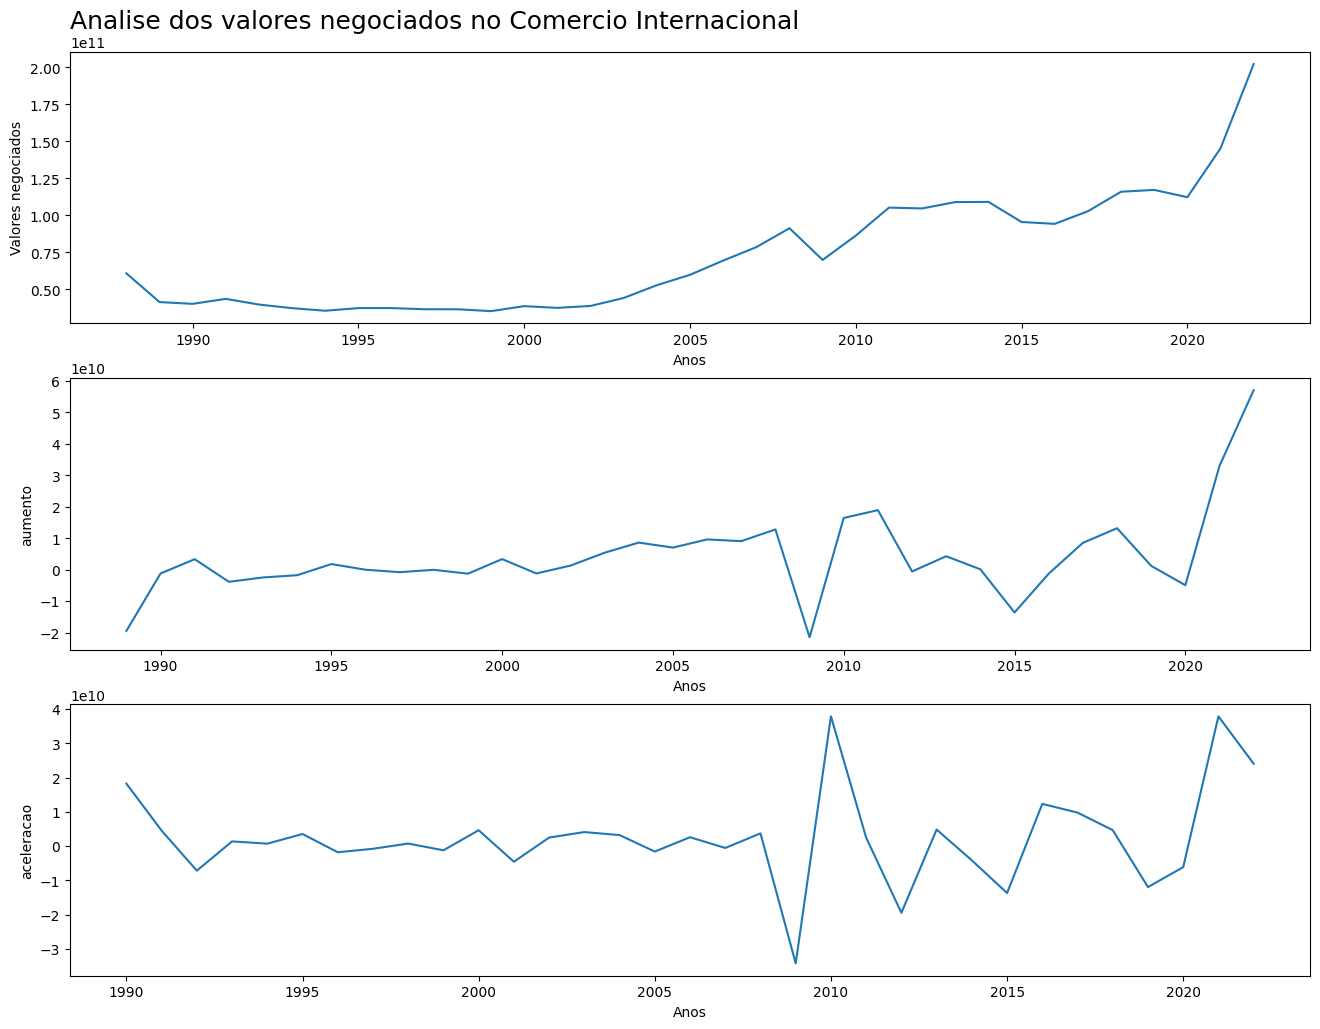

In [115]:
plot_comparacao('Anos','Valores negociados','aumento','aceleracao', df_total_values_corrigido,'Analise dos valores negociados no Comercio Internacional')

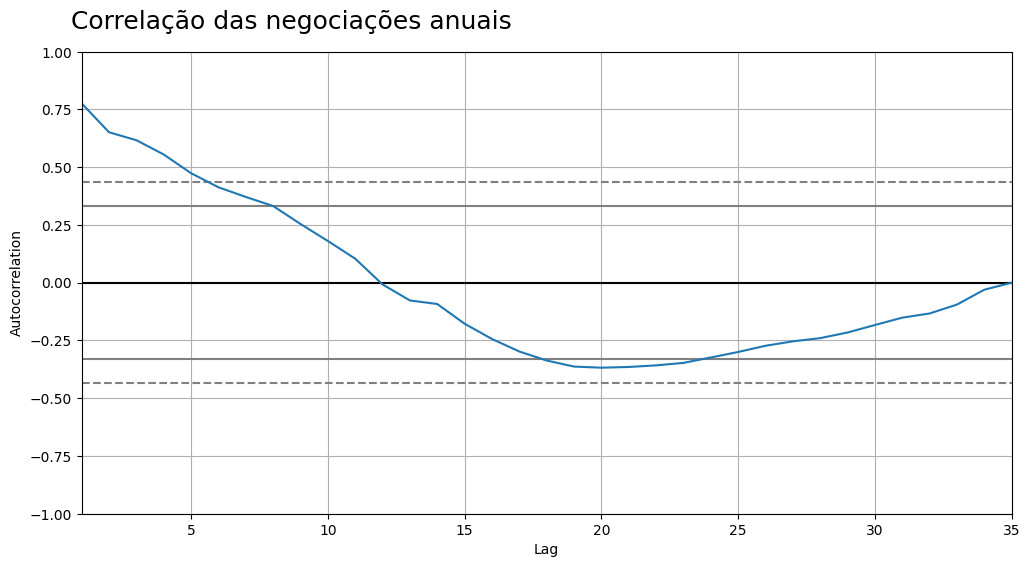

In [116]:
from pandas.plotting import autocorrelation_plot


ax = plt.figure(figsize=(12,6))
ax.suptitle('Correlação das negociações anuais', fontsize=18, x=0.3, y=0.95)
autocorrelation_plot(df_total_values_corrigido['Valores negociados'])
ax = ax

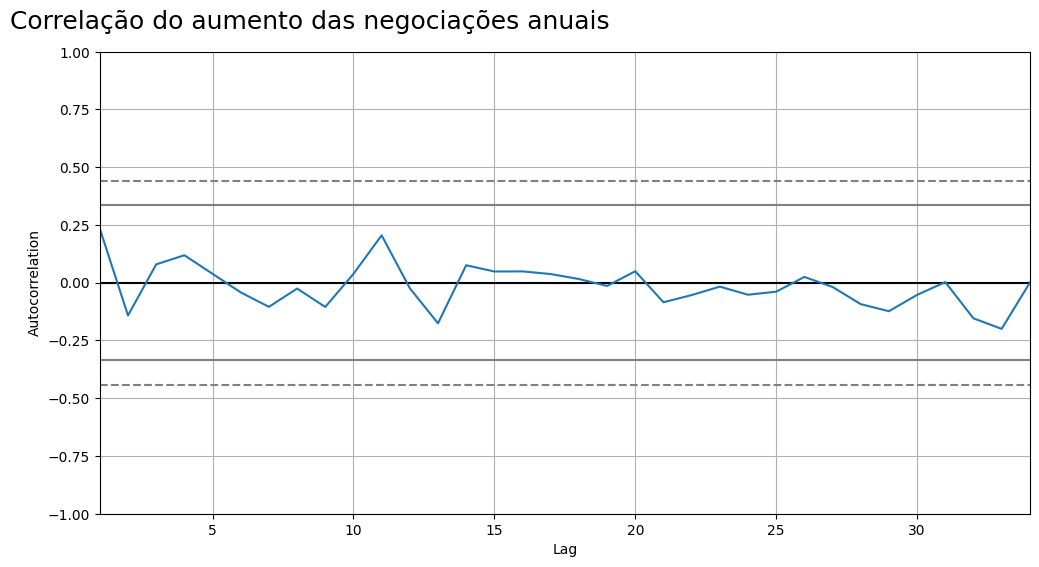

In [117]:
ax = plt.figure(figsize=(12,6))
ax.suptitle('Correlação do aumento das negociações anuais', fontsize=18, x=0.3, y=0.95)
autocorrelation_plot(df_total_values_corrigido['aumento'][1:])
ax = ax

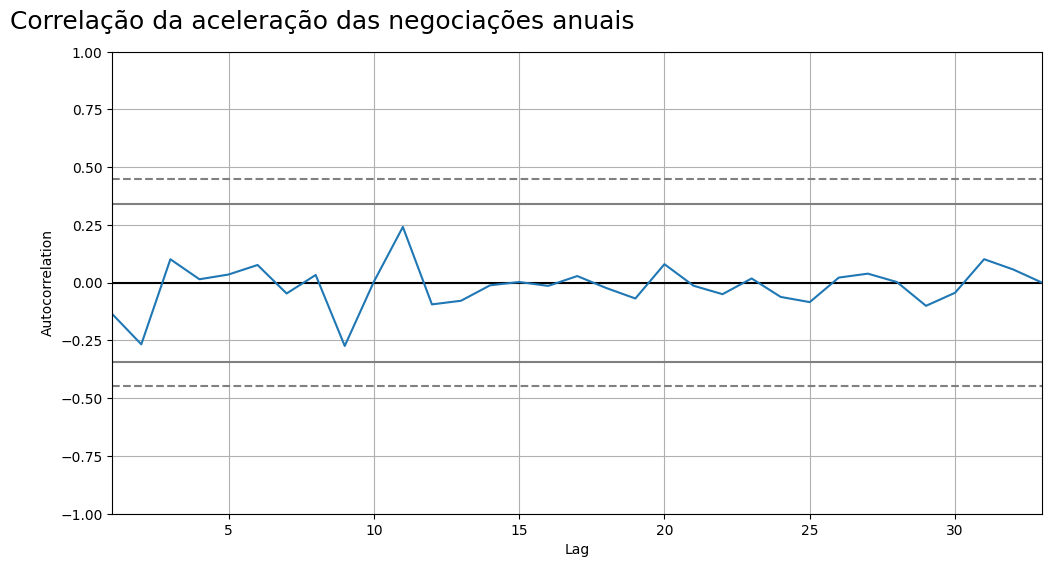

In [118]:
ax = plt.figure(figsize=(12,6))
ax.suptitle('Correlação da aceleração das negociações anuais', fontsize=18, x=0.3, y=0.95)
autocorrelation_plot(df_total_values_corrigido['aceleracao'][2:])
ax = ax

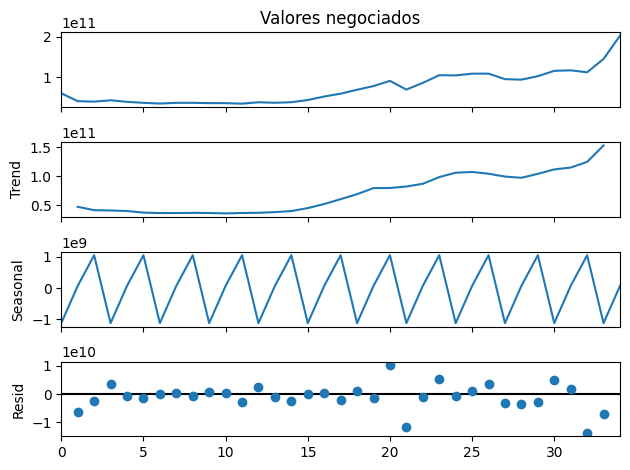

In [119]:
resultado = seasonal_decompose(df_total_values_corrigido['Valores negociados'],  period=3)
ax = resultado.plot()

## <font color='Red'> Parceiros Comerciais</font>

In [ ]:
mean_values = filtrado.groupby('Country')['Value'].mean()

top_countries = mean_values.sort_values(ascending=False).head(4)
pd.set_option('display.float_format', lambda x: '%.2f' % x)
print(top_countries)

Country
Asia             4329259.52
Europe           4001683.05
Eastern Asia     2418306.29
Western Europe   2005516.62
Name: Value, dtype: float64


In [ ]:
mean_values = filtrado.groupby('Country')['Value'].mean()

top_countries = mean_values.sort_values(ascending=False).head(17)
pd.set_option('display.float_format', lambda x: '%.2f' % x)
print(top_countries)

Country
Asia                            4329259.52
Europe                          4001683.05
Eastern Asia                    2418306.29
Western Europe                  2005516.62
Americas                        1760527.05
China                           1362552.67
Northern America                1176603.81
United States of America         905974.29
Germany                          836065.43
South-eastern Asia               787894.52
Northern Europe                  707531.62
Eastern Europe                   679063.29
Western Asia                     643711.90
Southern Europe                  609571.52
Latin America & the Caribbean    583923.24
Japan                            435956.71
Netherlands (Kingdom of the)     333649.05
Name: Value, dtype: float64


In [ ]:
mean_values = filtrado.groupby(['Series', 'Country'])['Value'].mean()

top_countries = mean_values.groupby('Series', group_keys=False).nlargest(14)

print(top_countries)

Series                                            Country                      
Balance imports/exports (millions of US dollars)  Asia                             541096.14
                                                  China                            424286.14
                                                  Eastern Asia                     420317.00
                                                  Germany                          177301.29
                                                  Russian Federation               168757.71
                                                  Western Asia                     164603.71
                                                  Western Europe                   161118.86
                                                  Eastern Europe                   135537.57
                                                  Europe                           108234.43
                                                  Saudi Arabia                     

In [ ]:
mean_values = filtrado.groupby(['System of trade', 'Country'])['Value'].mean()

top_countries = mean_values.groupby('System of trade', group_keys=False).nlargest(14)

print(top_countries)

System of trade  Country                      
-                Asia                            4329259.52
                 Europe                          4001683.05
                 Eastern Asia                    2418306.29
                 Western Europe                  2005516.62
                 Americas                        1760527.05
                 Northern America                1176603.81
                 South-eastern Asia               787894.52
                 Northern Europe                  707531.62
                 Eastern Europe                   679063.29
                 Western Asia                     643711.90
                 Southern Europe                  609571.52
                 Latin America & the Caribbean    583923.24
                 South America                    309027.90
                 Africa                           278352.48
G                China                           1362552.67
                 United States of America         905

In [ ]:
filtrado2 = filtrado[filtrado['Year'] == 2022]
mean_values = filtrado2.groupby('Country')['Value'].mean()

top_countries = mean_values.sort_values(ascending=False).head(20)
pd.set_option('display.float_format', lambda x: '%.2f' % x)
print(top_countries)

Country
Asia                            7079337.33
Europe                          5820770.33
Eastern Asia                    3765899.33
Western Europe                  2763222.00
Americas                        2706862.00
China                           2395734.33
Northern America                1773185.67
United States of America        1374726.67
South-eastern Asia              1305212.00
Western Asia                    1220994.33
Germany                         1110424.00
Eastern Europe                  1096313.33
Northern Europe                 1026601.00
Southern Europe                  934634.00
Latin America & the Caribbean    933676.00
Netherlands (Kingdom of the)     513538.00
Japan                            497781.33
South America                    488820.00
Italy                            466876.67
Republic of Korea                455730.67
Name: Value, dtype: float64


In [ ]:
geolocator = Nominatim(user_agent="my_geocoder")

countries = ['China', 'United States of America', 'Germany', 'Netherlands']

map_center = [0, 0]
zoom_level = 2

mymap = folium.Map(location=map_center, zoom_start=zoom_level)

for country in countries:
    location = geolocator.geocode(country)
    if location:
        folium.Marker(
            location=[location.latitude, location.longitude],
            popup=country
        ).add_to(mymap)

mymap.save("world_map.html")

mymap


### <font color='Grey'>Formatação e Pré-processamento</font>


Baixando o banco de dados.

In [149]:
parceiros = pd.read_csv('parceiros_comerciais.csv', skiprows = 1, encoding = 'latin1')

Removendo os NaN do banco para deixá-lo mais legível. Removendo a coluna 'System of trade footnote', que possui apenas dados de NaN.

In [ ]:
parceiros['Footnotes'] = parceiros['Footnotes'].fillna('-')

parceiros['Major trading partner 1 (% of exports) footnote'] = parceiros['Major trading partner 1 (% of exports) footnote'].fillna('-')

parceiros.columns.values[1] = 'Country'

parceiros = pd.DataFrame(parceiros)

In [ ]:
parceiros

### <font color='Grey'>Outliers</font>

Observando se há a presença de outliers.

As duas primeiras colunas são basicamente as mesmas. Dessa forma, observar se elas possuem o mesmo número de linhas é interessante.

In [ ]:
coluna = parceiros.iloc[:, 1]

paises = coluna.unique()

nomes = pd.Series(paises)
nomes_unicos = nomes.str.lower().unique()

print(nomes_unicos)


Observando se os anos estão dentro do esperado.

In [ ]:
tabela = pd.DataFrame({'Ano': parceiros['Year'].value_counts().index, 'Frequência': parceiros['Year'].value_counts().values}) ; print(tabela)

In [ ]:
tabela = pd.DataFrame({'Series': parceiros['Series'].value_counts().index, 'Frequência': parceiros['Series'].value_counts().values}) ; print(tabela)

In [ ]:
tabela = pd.DataFrame({'Trades': parceiros['Major trading partner 1 (% of exports)'].value_counts().index, 'Frequência': parceiros['Major trading partner 1 (% of exports)'].value_counts().values}) ; print(tabela)

In [ ]:
tabela = pd.DataFrame({'Notes': parceiros['Major trading partner 1 (% of exports) footnote'].value_counts().index, 'Frequência': parceiros['Major trading partner 1 (% of exports) footnote'].value_counts().values}) ; print(tabela)

In [ ]:
tabela = pd.DataFrame({'Fonte': parceiros['Footnotes'].value_counts().index, 'Frequência': parceiros['Footnotes'].value_counts().values}) ; print(tabela)

In [ ]:
tabela = pd.DataFrame({'Fonte': parceiros['Source'].value_counts().index, 'Frequência': parceiros['Source'].value_counts().values}) ; print(tabela)

In [ ]:
plt.boxplot(parceiros['Value'],  whis=[5, 95])

plt.xlabel('Values')
plt.ylabel('Frequency')

plt.show()

In [ ]:
mean = np.mean(parceiros['Value'])
std = np.std(parceiros['Value'])

threshold = 3
outliers = []
for x in parceiros['Value']:
    z_score = (x - mean) / std
    if abs(z_score) > threshold:
        outliers.append(x)
print("Mean: ",mean)
print("\nStandard deviation: ",std)
print("\nOutliers  : ", outliers)

In [ ]:
z_scores = np.abs((parceiros['Value'] - parceiros['Value'].mean()) / parceiros['Value'].std())

threshold = 3

outliers = parceiros[z_scores > threshold]

outliers

### <font color='Grey'>Maiores parceiros</font>

In [ ]:
filtrado = parceiros[parceiros.iloc[:, 1] == 'Brazil']
filtrado['Series'] = filtrado['Series'].str[-8:]
filtrado['Series'] = filtrado['Series'].str[:-1]
filtrado = filtrado[filtrado['Series'] == 'exports']
filtrado = filtrado[filtrado['Year'] == 2022]
filtrado

## Atividade 3 - Maiores Parceiros Comerciais do Brasil

In [ ]:
filtrado = parceiros[parceiros.iloc[:, 1] == 'Brazil']
filtrado['Series'] = filtrado['Series'].str[-8:]
filtrado['Series'] = filtrado['Series'].str[:-1]
filtrado = filtrado[filtrado['Series'] == 'exports']
filtrado = filtrado[filtrado['Year'] == 2022]
filtrado

## Atividade 4 - Commodities - Brasil

In [ ]:
filtrado = commodities[commodities['Country or Area'] == 'Brazil']
filtrado = filtrado[filtrado['Year'] == 2022]
filtrado

In [ ]:
filtrado = commodities[commodities['Country or Area'] == 'Argentina']
filtrado = filtrado[filtrado['Year'] == 2022]
filtrado

In [ ]:
filtrado = commodities[commodities['Country or Area'] == 'China']
filtrado = filtrado[filtrado['Year'] == 2022]
filtrado

In [ ]:
filtrado = commodities[commodities['Country or Area'] == 'USA']
filtrado = filtrado[filtrado['Year'] == 2022]
filtrado

### Mapas

In [ ]:
import folium
from geopy.geocoders import Nominatim
import osmnx as ox

geolocator = Nominatim(user_agent="my_geocoder")

countries_data = {
    'China': {'color': 'blue', 'Exportações': '3.593.601.435.602', 'Importações': '2.715.997.517.261'},
    'United States of America': {'color': 'green', 'Exportações': '2.062.089.832.731', 'Importações': '3.372.902.165.775'},
    'Argentina': {'color': 'yellow', 'Exportações': '88.445.718.838', 'Importações': '81.522.681.076'},
    'Brazil': {'color': 'red', 'Exportações': '334.463.079.195', 'Importações': '292.343.725.728'}
}

countries = list(countries_data.keys())

map_center = [0, 0]
zoom_level = 2
mymap = folium.Map(location=map_center, zoom_start=zoom_level)

for country in countries:
    location = geolocator.geocode(country)
    if location:
        valor1 = countries_data[country]['Exportações']
        valor2 = countries_data[country]['Importações']
        folium.Marker(
            location=[location.latitude, location.longitude],
            popup=f"{country}: 'Exportações:' {valor1} 'Importações:' {valor2}"
        ).add_to(mymap)

for country in countries:
    borders = ox.geocode_to_gdf(country)
    style_data = {
        'color': countries_data[country]['color'],
        'fillColor': countries_data[country]['color'],
        'fillOpacity': 0.4
    }
    folium.GeoJson(borders.to_json(), style_function=lambda x, style_data=style_data: style_data).add_to(mymap)

mymap




### Commodities Específicas

In [ ]:
commodity12 = pd.read_csv('/content/soja.csv', encoding = 'latin1')

In [ ]:
commodity72 = pd.read_csv('/content/ferro.csv', encoding = 'latin1')

In [ ]:
commodity27 = pd.read_csv('/content/petroleo.csv', encoding = 'latin1')

#### Importações

In [ ]:
commodity12_imp = commodity12[commodity12['Flow'] == 'Import']
commodity12_imp = commodity12_imp[commodity12_imp['Year'] == 2022]
commodity12_imp

In [ ]:
numero1 = commodity12_imp['Trade (USD)'].sum()
print(numero1)

In [ ]:
commodity72_imp = commodity72[commodity72['Flow'] == 'Import']
commodity72_imp = commodity72_imp[commodity72_imp['Year'] == 2022]
commodity72_imp

In [ ]:
numero2 = commodity72_imp['Trade (USD)'].sum()
print(numero2)

In [ ]:
commodity27_imp = commodity27[commodity27['Flow'] == 'Import']
commodity27_imp = commodity27_imp[commodity27_imp['Year'] == 2022]
commodity27_imp

In [ ]:
numero3 = commodity27_imp['Trade (USD)'].sum()
print(numero3)

In [ ]:
data = {
    'País': ['Brazil', 'Brazil', 'Brazil'],
    'Commodity': ['Commodity 27', 'Commodity 72', 'Commodity 12'],
    'Trade(USD)': [51938939467, 4732721115, 429317976],
    'MatériaPrima': ['Óleos Minerais', 'Ferro e Metal', 'Sementes e Óleos Vegetais']
}

data_brasil = pd.DataFrame(data)

print(data_brasil)

In [ ]:
plt.figure(figsize=(12, 8))

colors = plt.cm.viridis(np.linspace(0, 1, len(data_brasil['Commodity'])))

squarify.plot(sizes=data_brasil['Trade(USD)'], label=["" for _ in data_brasil['Commodity']], color=colors, alpha=0.8)

plt.title('Trade em Dólares por Importação de Matéria Prima de cada Commodity no Brasil em 2022')
plt.axis('off')

for color, label in zip(colors, data_brasil['MatériaPrima']):
    plt.scatter([], [], color=color, label=label)

plt.legend(title='Matéria Prima', bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)

plt.tight_layout()
plt.show()

#### Exportações

In [ ]:
commodity12_exp = commodity12[commodity12['Flow'] == 'Export']
commodity12_exp = commodity12_exp[commodity12_exp['Year'] == 2022]
commodity12_exp

In [ ]:
numero1 = commodity12_exp['Trade (USD)'].sum()
print(numero1)

In [ ]:
commodity72_exp = commodity72[commodity72['Flow'] == 'Export']
commodity72_exp = commodity72_exp[commodity72_exp['Year'] == 2022]
commodity72_exp

In [ ]:
numero2 = commodity72_exp['Trade (USD)'].sum()
print(numero2)

In [ ]:
commodity27_exp = commodity27[commodity27['Flow'] == 'Export']
commodity27_exp = commodity27_exp[commodity27_exp['Year'] == 2022]
commodity27_exp

In [ ]:
numero3 = commodity27_exp['Trade (USD)'].sum()
print(numero3)

In [ ]:
data = {
    'País': ['Brazil', 'Brazil', 'Brazil'],
    'Commodity': ['Commodity 27', 'Commodity 72', 'Commodity 12'],
    'Trade(USD)': [numero1, numero2, numero3],
    'MatériaPrima': ['Óleos Minerais', 'Ferro e Metal', 'Sementes e Óleos Vegetais']
}

data_brasil = pd.DataFrame(data)

print(data_brasil)

In [ ]:
plt.figure(figsize=(12, 8))

colors = plt.cm.viridis(np.linspace(0, 1, len(data_brasil['Commodity'])))

squarify.plot(sizes=data_brasil['Trade(USD)'], label=["" for _ in data_brasil['Commodity']], color=colors, alpha=0.8)

plt.title('Trade em Dólares por Exportação de Matéria Prima de cada Commodity no Brasil em 2022')
plt.axis('off')

for color, label in zip(colors, data_brasil['MatériaPrima']):
    plt.scatter([], [], color=color, label=label)

plt.legend(title='Matéria Prima', bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)

plt.tight_layout()
plt.show()